In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
import seaborn as sns
from scipy import stats
from typing import Dict, Tuple, List
import warnings
import nilearn.plotting as plotting
import pickle
import scipy.io as sio
from pprint import pprint
import nibabel as nib
import h5py
from nilearn import datasets
# from nilearn import plotting

In [73]:
# Global configurations
code_directory = '/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/code'
os.chdir(code_directory)
base_path_results = '../results'
base_path_data = '../Data'

##Mann-Whitney U test with correction for multiple comparisons

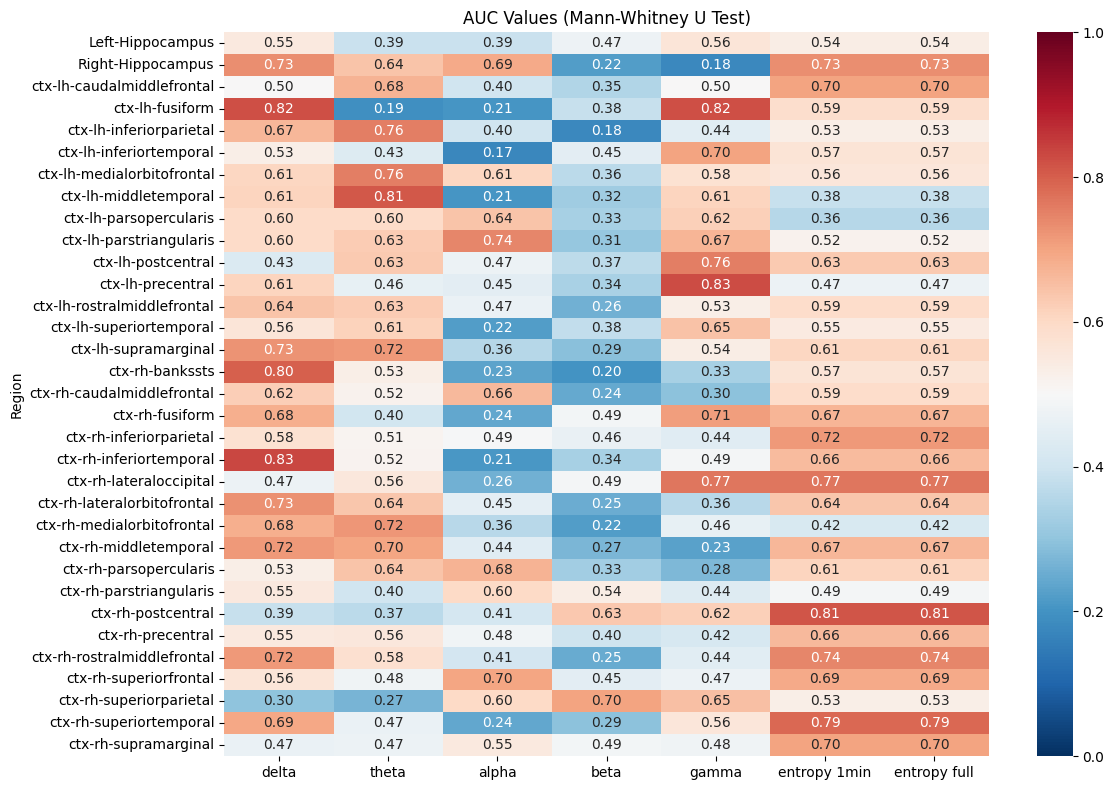


Effect Size Summary:

Large effects (|AUC - 0.5| ≥ 0.21): 53
Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): 54
Small effects (0.06 ≤ |AUC - 0.5| < 0.14): 67

Top 5 Largest Effects:
ctx-rh-inferiortemporal - deltaRel_mean: AUC = 0.832 (HUP > MNI), p = 0.0065
ctx-lh-precentral - gammaRel_mean: AUC = 0.827 (HUP > MNI), p = 0.0159
ctx-lh-inferiortemporal - alphaRel_mean: AUC = 0.174 (MNI > HUP), p = 0.0037
ctx-lh-inferiorparietal - betaRel_mean: AUC = 0.178 (MNI > HUP), p = 0.0599
Right-Hippocampus - gammaRel_mean: AUC = 0.178 (MNI > HUP), p = 0.0599


In [74]:
def compute_mann_whitney_stats(group1: np.ndarray, 
                             group2: np.ndarray) -> Tuple[float, float, float]:
    """
    Compute Mann-Whitney U statistic and derive AUC.
    
    Parameters:
    -----------
    group1, group2 : np.ndarray
        Arrays containing measurements for each group
        
    Returns:
    --------
    Tuple[float, float, float]
        (U statistic, AUC, p-value)
    """
    stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    n1, n2 = len(group1), len(group2)
    
    # Convert U statistic to AUC
    auc = stat / (n1 * n2)
    
    return stat, auc, p_value

def analyze_effect_sizes_mw(hup_features: pd.DataFrame, 
                          mni_features: pd.DataFrame, 
                          min_patients: int = 5) -> Dict:
    """
    Compute Mann-Whitney U statistics and AUC for all region-feature pairs.
    Includes multiple comparison corrections.
    """
    feature_columns = [
        'deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 'betaRel_mean',
        'gammaRel_mean', 'entropy_1min_mean', 'entropy_fullts_mean'
    ]
    
    common_regions = set(hup_features['roi'].unique()) & set(mni_features['roi'].unique())
    
    results = {}
    all_p_values = []  # Store all p-values for multiple comparison correction
    region_feature_pairs = []  # Store corresponding region-feature pairs
    
    for region in common_regions:
        # Get patient counts
        hup_patients = hup_features[hup_features['roi'] == region]['patient_id'].nunique()
        mni_patients = mni_features[mni_features['roi'] == region]['patient_id'].nunique()
        
        if hup_patients < min_patients or mni_patients < min_patients:
            continue
            
        results[region] = {}
        
        for feature in feature_columns:
            hup_data = hup_features[hup_features['roi'] == region][feature].values
            mni_data = mni_features[mni_features['roi'] == region][feature].values
            
            # Compute statistics
            u_stat, auc, p_value = compute_mann_whitney_stats(hup_data, mni_data)
            
            # Store p-value and pair for correction
            all_p_values.append(p_value)
            region_feature_pairs.append((region, feature))
            
            results[region][feature] = {
                'U_statistic': u_stat,
                'AUC': auc,
                'p_value': p_value,
                'hup_n': len(hup_data),
                'mni_n': len(mni_data)
            }
    
    # Perform multiple comparison corrections
    all_p_values = np.array(all_p_values)
    
    # Bonferroni correction
    bonferroni_threshold = 0.05 / len(all_p_values)
    bonferroni_significant = all_p_values < bonferroni_threshold
    
    # FDR correction (Benjamini-Hochberg)
    from statsmodels.stats.multitest import multipletests
    _, p_values_fdr, _, _ = multipletests(all_p_values, method='fdr_bh')
    
    # Add correction results to the dictionary
    for (region, feature), p_orig, p_fdr, is_bonf_sig in zip(
            region_feature_pairs, all_p_values, p_values_fdr, bonferroni_significant):
        results[region][feature].update({
            'p_value_bonferroni_threshold': bonferroni_threshold,
            'significant_bonferroni': is_bonf_sig,
            'p_value_fdr': p_fdr,
            'significant_fdr': p_fdr < 0.05
        })
    
    return results

def visualize_mw_results(results: Dict):
    """
    Create visualizations for Mann-Whitney test results with multiple comparison corrections.
    """
    # Define feature order and mapping
    feature_order = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean', 
        'entropy_1min_mean', 
        'entropy_fullts_mean'
    ]
    
    feature_name_mapping = {
        'deltaRel_mean': 'delta',
        'thetaRel_mean': 'theta', 
        'alphaRel_mean': 'alpha',
        'betaRel_mean': 'beta',
        'gammaRel_mean': 'gamma',
        'entropy_1min_mean': 'entropy 1min',
        'entropy_fullts_mean': 'entropy full'
    }
    
    # Convert results to DataFrame
    df_list = []
    for region in results:
        for feature in results[region]:
            res = results[region][feature]
            df_list.append({
                'Region': region,
                'Feature': feature,
                'AUC': res['AUC'],
                'p_value': res['p_value'],
                'p_value_fdr': res['p_value_fdr'],
                'significant_bonferroni': res['significant_bonferroni'],
                'significant_fdr': res['significant_fdr']
            })
    
    df = pd.DataFrame(df_list)
    
    # 1. Heatmap of AUC values
    plt.figure(figsize=(12, 8))
    heatmap_data = df.pivot(index='Region', columns='Feature', values='AUC')
    heatmap_data = heatmap_data[feature_order]
    heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]
    
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0.5,
                vmin=0, vmax=1, annot=True, fmt='.2f')
    plt.title('AUC Values (Mann-Whitney U Test)')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Compute effect magnitudes
    df['effect_magnitude'] = abs(df['AUC'] - 0.5)
    
    # Print significance analysis
    print("\nSignificance Analysis:")
    print("=" * 50)
    n_tests = len(df)
    n_uncorrected = df[df['p_value'] < 0.05].shape[0]
    n_fdr = df[df['significant_fdr']].shape[0]
    n_bonf = df[df['significant_bonferroni']].shape[0]
    
    print(f"\nTotal tests performed: {n_tests}")
    print(f"Significant before correction (p < 0.05): {n_uncorrected}")
    print(f"Significant after FDR correction: {n_fdr}")
    print(f"Significant after Bonferroni correction: {n_bonf}")
    
    # Print top effects with corrections
    print("\nTop 5 Largest Effects with Multiple Comparison Corrections:")
    print("=" * 50)
    top_effects = df.nlargest(5, 'effect_magnitude')
    for _, row in top_effects.iterrows():
        region, feature = row['Region'], row['Feature']
        direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
        print(f"\n{region} - {feature}:")
        print(f"  AUC = {row['AUC']:.3f} ({direction})")
        print(f"  Original p = {row['p_value']:.4f}")
        print(f"  FDR-corrected p = {row['p_value_fdr']:.4f}")
        
        # Print significance levels
        significance = []
        if row['significant_bonferroni']:
            significance.append("Significant after Bonferroni")
        elif row['significant_fdr']:
            significance.append("Significant after FDR")
        elif row['p_value'] < 0.05:
            significance.append("Only significant before correction")
        else:
            significance.append("Not significant")
        print(f"  Significance: {significance[0]}")

    # Print summary by effect size
    print("\nEffect Size Distribution:")
    print("=" * 50)
    large = df[df['effect_magnitude'] >= 0.21].shape[0]
    medium = df[(df['effect_magnitude'] >= 0.14) & (df['effect_magnitude'] < 0.21)].shape[0]
    small = df[(df['effect_magnitude'] >= 0.06) & (df['effect_magnitude'] < 0.14)].shape[0]
    
    print(f"\nLarge effects (|AUC - 0.5| ≥ 0.21): {large}")
    print(f"Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): {medium}")
    print(f"Small effects (0.06 ≤ |AUC - 0.5| < 0.14): {small}")
    
    # Print significant effects after correction
    print("\nSignificant Effects After Correction:")
    print("=" * 50)
    sig_after_correction = df[df['significant_fdr']].sort_values('effect_magnitude', ascending=False)
    
    if len(sig_after_correction) > 0:
        print("\nTop significant effects after FDR correction:")
        for _, row in sig_after_correction.head().iterrows():
            direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
            print(f"\n{row['Region']} - {feature_name_mapping[row['Feature']]}:")
            print(f"  AUC = {row['AUC']:.3f} ({direction})")
            print(f"  FDR-corrected p = {row['p_value_fdr']:.4f}")
    # [previous visualization code remains the same]
    
    # Print summary statistics with multiple comparison corrections
    print("\nMultiple Comparison Correction Summary:")
    print("=" * 50)
    
    # Count significant results
    n_total = sum(len(results[region]) for region in results)
    n_sig_uncorrected = sum(
        1 for region in results for feature in results[region]
        if results[region][feature]['p_value'] < 0.05
    )
    n_sig_bonferroni = sum(
        1 for region in results for feature in results[region]
        if results[region][feature]['significant_bonferroni']
    )
    n_sig_fdr = sum(
        1 for region in results for feature in results[region]
        if results[region][feature]['significant_fdr']
    )
    
    print(f"\nTotal number of tests: {n_total}")
    print(f"Significant results (uncorrected p < 0.05): {n_sig_uncorrected}")
    print(f"Significant results (Bonferroni corrected): {n_sig_bonferroni}")
    print(f"Significant results (FDR corrected): {n_sig_fdr}")
    
    # Print top effects with corrected p-values
    print("\nTop 5 Largest Effects (with corrections):")
    df['effect_size'] = abs(df['AUC'] - 0.5)
    top_effects = df.nlargest(5, 'effect_size')
    for _, row in top_effects.iterrows():
        region, feature = row['Region'], row['Feature']
        result = results[region][feature]
        direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
        print(f"\n{region} - {feature}:")
        print(f"  AUC = {row['AUC']:.3f} ({direction})")
        print(f"  Original p = {result['p_value']:.4f}")
        print(f"  FDR-corrected p = {result['p_value_fdr']:.4f}")
        print(f"  Significant after Bonferroni: {'Yes' if result['significant_bonferroni'] else 'No'}")
        print(f"  Significant after FDR: {'Yes' if result['significant_fdr'] else 'No'}")


def visualize_mw_results(results: Dict):
    """
    Create visualizations for Mann-Whitney test results.
    """
    # Define feature order and mapping
    feature_order = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean', 
        'entropy_1min_mean', 
        'entropy_fullts_mean'
    ]
    
    feature_name_mapping = {
        'deltaRel_mean': 'delta',
        'thetaRel_mean': 'theta', 
        'alphaRel_mean': 'alpha',
        'betaRel_mean': 'beta',
        'gammaRel_mean': 'gamma',
        'entropy_1min_mean': 'entropy 1min',
        'entropy_fullts_mean': 'entropy full'
    }
    
    # Convert results to DataFrame
    df_list = []
    for region in results:
        for feature in results[region]:
            res = results[region][feature]
            df_list.append({
                'Region': region,
                'Feature': feature,
                'AUC': res['AUC'],
                'p_value': res['p_value']
            })
    
    df = pd.DataFrame(df_list)
    
    # 1. Heatmap of AUC values
    plt.figure(figsize=(12, 8))
    heatmap_data = df.pivot(index='Region', columns='Feature', values='AUC')
    # Reorder columns according to feature_order
    heatmap_data = heatmap_data[feature_order]
    # Rename columns with simplified names
    heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]
    
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0.5,
                vmin=0, vmax=1, annot=True, fmt='.2f')
    plt.title('AUC Values (Mann-Whitney U Test)')
    # Rotate x-axis labels to horizontal
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nEffect Size Summary:")
    print("=" * 50)
    
    # Count effects by size
    large_effects = df[abs(df['AUC'] - 0.5) >= 0.21].shape[0]  # |AUC - 0.5| ≥ 0.21 for large effect
    medium_effects = df[(abs(df['AUC'] - 0.5) >= 0.14) & 
                       (abs(df['AUC'] - 0.5) < 0.21)].shape[0]
    small_effects = df[(abs(df['AUC'] - 0.5) >= 0.06) & 
                      (abs(df['AUC'] - 0.5) < 0.14)].shape[0]
    
    print(f"\nLarge effects (|AUC - 0.5| ≥ 0.21): {large_effects}")
    print(f"Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): {medium_effects}")
    print(f"Small effects (0.06 ≤ |AUC - 0.5| < 0.14): {small_effects}")
    
    # Print top effects
    print("\nTop 5 Largest Effects:")
    df['effect_size'] = abs(df['AUC'] - 0.5)
    top_effects = df.nlargest(5, 'effect_size')
    for _, row in top_effects.iterrows():
        direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
        print(f"{row['Region']} - {row['Feature']}: "
              f"AUC = {row['AUC']:.3f} ({direction}), "
              f"p = {row['p_value']:.4f}")

def main():
    """
    Main function to run the Mann-Whitney analysis.
    """
    # Load data
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Run analysis
    results = analyze_effect_sizes_mw(
        hup_region_features,
        mni_region_features,
        min_patients=5
    )
    
    # Save results dictionary
    with open(os.path.join(base_path_results, 'mann_whitney_results.pkl'), 'wb') as f:
        pickle.dump(results, f)
    
    # Also save as a more readable format for inspection
    # Convert nested dictionary to DataFrame
    results_df = []
    for region in results:
        for feature in results[region]:
            result = results[region][feature]
            results_df.append({
                'Region': region,
                'Feature': feature,
                **result  # Unpack all statistics
            })
    
    results_df = pd.DataFrame(results_df)
    results_df.to_csv(os.path.join(base_path_results, 'mann_whitney_results.csv'), index=False)
    
    # Visualize results
    visualize_mw_results(results)

if __name__ == "__main__":
    main()

In [75]:
def inspect_results(base_path_results: str):
    """
    Load and inspect the saved Mann-Whitney results
    
    Parameters:
    -----------
    base_path_results : str
        Path to the results directory
    """
    # Load pickle file
    results_path = os.path.join(base_path_results, 'mann_whitney_results.pkl')
    
    print(f"Looking for results file at: {results_path}")
    
    if not os.path.exists(results_path):
        print(f"Results file not found at {results_path}")
        return
        
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    
    # Print basic structure
    print("\nResults Structure:")
    print("=" * 50)
    print(f"Number of regions: {len(results)}")
    print("\nFirst region contents:")
    first_region = next(iter(results))
    print(f"\nRegion: {first_region}")
    pprint(results[first_region])
    
    # Print features available
    print("\nFeatures in results:")
    print("=" * 50)
    features = set()
    for region in results:
        features.update(results[region].keys())
    print("\n".join(sorted(features)))
    
    return results

# Run inspection
results = inspect_results(base_path_results)

Looking for results file at: ../results/mann_whitney_results.pkl

Results Structure:
Number of regions: 33

First region contents:

Region: ctx-lh-inferiorparietal
{'alphaRel_mean': {'AUC': np.float64(0.4),
                   'U_statistic': np.float64(18.0),
                   'hup_n': 9,
                   'mni_n': 5,
                   'p_value': np.float64(0.6063936063936064),
                   'p_value_bonferroni_threshold': 0.00021645021645021645,
                   'p_value_fdr': np.float64(0.8593676262387919),
                   'significant_bonferroni': np.False_,
                   'significant_fdr': np.False_},
 'betaRel_mean': {'AUC': np.float64(0.17777777777777778),
                  'U_statistic': np.float64(8.0),
                  'hup_n': 9,
                  'mni_n': 5,
                  'p_value': np.float64(0.05994005994005994),
                  'p_value_bonferroni_threshold': 0.00021645021645021645,
                  'p_value_fdr': np.float64(0.42898198953074085),


The results are stored as a nested dictionary with the following structure:

{
    region_name: {
        feature_name: {
            'AUC': float,
            'U_statistic': float,
            'hup_n': int,
            'mni_n': int,
            'p_value': float,
            'p_value_bonferroni_threshold': float,
            'p_value_fdr': float,
            'significant_bonferroni': bool,
            'significant_fdr': bool
        },
        ...
    },
    ...
}

e.g. For a region like ctx-lh-inferiorparietal and feature alphaRel_mean:

{
    'AUC': 0.4,
    'U_statistic': 18.0,
    'hup_n': 9,
    'mni_n': 5,
    'p_value': 0.6063936063936064,
    'p_value_bonferroni_threshold': 0.00021645021645021645,
    'p_value_fdr': 0.8593676262387919,
    'significant_bonferroni': False,
    'significant_fdr': False
}

brainplot.py

Coordinate Extraction:
Extracts MNI coordinates (mni_x, mni_y, mni_z) for regions using niplot.find_parcellation_cut_coords.
Maps region labels (roiNum) to the atlas look-up table (LUT) via a merge operation.

Interactive Visualization:
Generates a 3D interactive plot with markers for regions and displays region abbreviations (abvr).
Opens this visualization in a web browser.
Static Visualization:

Creates a static 3D brain plot with uniform marker sizes for all regions.

In [76]:
from nilearn import plotting as niplot

In [77]:
# Global configurations
code_directory = '/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/code'
os.chdir(code_directory)  # Set working directory to code directory

# Paths to Data and Results folders
base_path_results = '../results'  # Results folder at the same level as code
base_path_data = '../Data'  # Data folder at the same level as code

# Paths to data files
desikan_killiany = os.path.abspath(os.path.join(base_path_data, 'aparc+aseg.nii.gz'))
atlas_LUT = os.path.abspath(os.path.join(base_path_data, 'desikanKilliany.csv'))

# Ensure the files exist
assert os.path.exists(desikan_killiany), f"Atlas file not found: {desikan_killiany}"
assert os.path.exists(atlas_LUT), f"LUT file not found: {atlas_LUT}"

In [78]:
print(base_path_data)
print(base_path_results)

../Data
../results


In [79]:
def get_node_coords(atlas, atlas_LUT):
    coords, labels = niplot.find_parcellation_cut_coords(atlas, return_label_names=True)
    labels = np.array(labels, dtype=np.int64)  # Ensure consistent data typing
    
    atlas_coord = pd.DataFrame({
        'roiNum': labels,
        'mni_x': coords[:, 0], 
        'mni_y': coords[:, 1], 
        'mni_z': coords[:, 2]
    })
    
    atlas_LUT_df = pd.read_csv(atlas_LUT)  # Load LUT
    atlas_coord = pd.merge(atlas_LUT_df, atlas_coord, on='roiNum', how='inner')
    atlas_coord.to_csv(os.path.join(base_path_results, 'atlas_coord.csv'), index=False)
    return atlas_coord

if __name__ == "__main__":
    print(f"Using atlas path: {desikan_killiany}")
    print(f"Using LUT path: {atlas_LUT}")
    atlas_coord = get_node_coords(atlas=desikan_killiany, atlas_LUT=atlas_LUT)
    view = niplot.view_markers(
        atlas_coord[['mni_x', 'mni_y', 'mni_z']],  # Coordinates
        marker_color='red',
        marker_size=10,
        marker_labels=atlas_coord['abvr'].tolist()  # Region abbreviations
    )
    view.open_in_browser()  # Launch interactive visualization

Using atlas path: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/aparc+aseg.nii.gz
Using LUT path: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/desikanKilliany.csv


Red dots: Each red dot represents a region of interest (ROI) extracted from the brain atlas (aparc+aseg.nii.gz).
Gray brain model: The background is a 3D rendering of a standard brain template.
Region labels: The text next to each dot (e.g., CaMFG_L, Tpole_R) corresponds to abbreviations of the regions as specified in the LUT (abvr column).
Each red dot is mapped to the MNI coordinates of a specific ROI from the brain atlas.

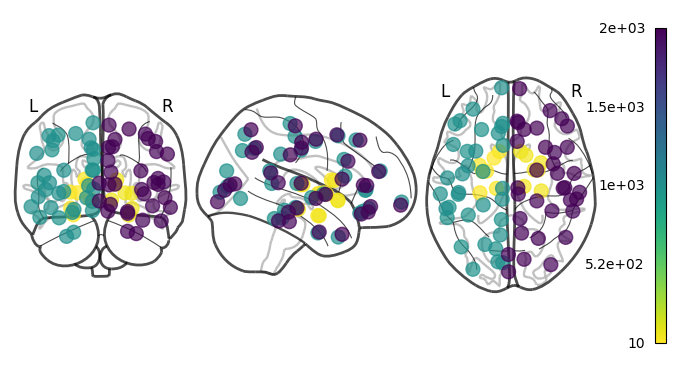

In [80]:
niplot.plot_markers(
    atlas_coord['roiNum'],  # Use roiNum or another column for marker values
    atlas_coord[['mni_x', 'mni_y', 'mni_z']].values  # Coordinates for each point
)

Colored dots: Each dot represents a region of interest (ROI) from the brain atlas.
Brain projections: Three orthogonal views (coronal, sagittal, and axial) of the brain are displayed, with dots projected onto the respective slices.
Color gradient: The color of each dot represents the value of a specific variable (e.g., roiNum or other column chosen for marker_values).

Visualizing HUP in terms of the normative atlas from MNI

In [81]:
import scipy.io as sio
import pandas as pd
import numpy as np
import nilearn.plotting as niplot

In [82]:
# Load data
hup_atlas = sio.loadmat(os.path.join(base_path_data, 'HUP_atlas.mat'))  # Load HUP atlas
hup_df = pd.read_csv(os.path.join(base_path_data, 'hup_df.csv'))  # Load hup_df

# Extract mni_coords from hup_atlas
mni_coords = hup_atlas['mni_coords']
if len(mni_coords.shape) > 2:  # Flatten if needed
    mni_coords = mni_coords.reshape(-1, 3)

# Convert mni_coords to DataFrame
mni_coords_df = pd.DataFrame(mni_coords, columns=['mni_x', 'mni_y', 'mni_z'])

# Concatenate hup_df with mni_coords
hup_atlas_with_roiNum = pd.concat([mni_coords_df, hup_df.reset_index(drop=True)], axis=1)

# Save the concatenated DataFrame to a CSV file for inspection
output_path = os.path.join(base_path_data, 'hup_atlas_with_roiNum.csv')
hup_atlas_with_roiNum.to_csv(output_path, index=False)

print(f"Concatenated DataFrame saved to {output_path}")

Concatenated DataFrame saved to ../Data/hup_atlas_with_roiNum.csv


In [83]:
hup_atlas_with_roiNum_path = os.path.join(base_path_data, 'hup_atlas_with_roiNum.csv')

redo

In [84]:
desikan_killiany_df = pd.read_csv(os.path.join(base_path_data, 'desikanKilliany.csv'))
# Create a mapping from region name (roi) to roiNum
region_to_roiNum = desikan_killiany_df.set_index('roi')['roiNum'].to_dict()


In [85]:
# Populate AUC DataFrame with mapped roiNum
auc_data = []
for region_name, features in results.items():
    roi_num = region_to_roiNum.get(region_name)  # Map region name to roiNum
    if roi_num is not None:
        auc_value = features.get('deltaRel_mean', {}).get('AUC', None)  # Example feature
        if auc_value is not None:
            auc_data.append({'roiNum': roi_num, 'AUC': auc_value})

# Convert to DataFrame
auc_df = pd.DataFrame(auc_data)
print("AUC DataFrame:", auc_df.head())

AUC DataFrame:    roiNum       AUC
0    1008  0.666667
1    2008  0.576471
2    1030  0.564286
3    2022  0.386667
4    2030  0.693333


In [86]:
# Merge AUC values with HUP atlas (MNI coordinates + roiNum)
merged_df = pd.merge(hup_atlas_with_roiNum, auc_df, on='roiNum', how='inner')
print("Merged DataFrame for Visualization:", merged_df.head())


Merged DataFrame for Visualization:       mni_x     mni_y      mni_z         x         y          z  roiNum  snum  \
0 -23.43390  39.08790  25.165136 -23.43390  39.08790  25.165136    1027    40   
1  21.70795  30.04245  22.902119  21.70795  30.04245  22.902119    2028    75   
2  24.49635  31.18205  26.183199  24.49635  31.18205  26.183199    2027    74   
3  23.55175  14.36600 -15.279428  23.55175  14.36600 -15.279428    2012    59   
4  21.70795  30.04245  22.902119  21.70795  30.04245  22.902119    2028    75   

      abvr     lobe  isSideLeft       AUC  
0   RMFr_L  Frontal           1  0.642857  
1   SpFr_R  Frontal           0  0.562500  
2   RMFr_R  Frontal           0  0.715909  
3  LObFr_R  Frontal           0  0.730000  
4   SpFr_R  Frontal           0  0.562500  


In [87]:
from matplotlib import cm, colors, pyplot as plt

# Normalize the AUC values between 0 and 1
norm = colors.Normalize(vmin=merged_df['AUC'].min(), vmax=merged_df['AUC'].max())

# Use pyplot to get the colormap
cmap = plt.get_cmap('viridis')  # Alternatively, cm.viridis directly works in many versions
marker_colors = cmap(norm(merged_df['AUC']))

In [88]:
# # Interactive visualization - eld lvl
# view = niplot.view_markers(
#     marker_coords=merged_df[['mni_x', 'mni_y', 'mni_z']].values,  # MNI coordinates
#     marker_color=marker_colors,  # RGBA colors derived from AUC values
#     marker_size=8,  # Uniform marker size
#     marker_labels=merged_df['abvr'].tolist()  # Use region abbreviations as labels
# )
# view.open_in_browser()  # Launch interactive visualization in the browser

In [89]:
# Step 1: Filter merged_df to include only rows with roiNum in AUC DataFrame
filtered_df = merged_df[merged_df['roiNum'].isin(auc_df['roiNum'])]

# Step 2: Aggregate by roiNum to create one point per region
aggregated_df = filtered_df.groupby('roiNum').agg({
    'mni_x': 'mean',
    'mni_y': 'mean',
    'mni_z': 'mean',
    'AUC': 'mean',  # Retain AUC values
    'abvr': 'first'  # Use the first abbreviation for each region
}).reset_index()

# Verify: Check number of unique regions
print(f"Number of regions in aggregated_df: {aggregated_df['roiNum'].nunique()}")
print(f"Regions in aggregated_df: {aggregated_df['roiNum'].tolist()}")
print(f"Regions in auc_df: {auc_df['roiNum'].tolist()}")

# Ensure all regions in aggregated_df match those in auc_df
assert set(aggregated_df['roiNum']) == set(auc_df['roiNum']), "Mismatch in regions!"


Number of regions in aggregated_df: 33
Regions in aggregated_df: [17, 53, 1003, 1007, 1008, 1009, 1014, 1015, 1018, 1020, 1022, 1024, 1027, 1030, 1031, 2001, 2003, 2007, 2008, 2009, 2011, 2012, 2014, 2015, 2018, 2020, 2022, 2024, 2027, 2028, 2029, 2030, 2031]
Regions in auc_df: [1008, 2008, 1030, 2022, 2030, 1015, 1009, 2015, 1014, 2029, 1018, 2020, 1024, 17, 2012, 1007, 1022, 2014, 2028, 2031, 2009, 1027, 2011, 2001, 2027, 2018, 1031, 1003, 1020, 2007, 2024, 2003, 53]


In [90]:
# Verify number of regions in AUC computation
print(f"Number of regions in aggregated_df: {aggregated_df['roiNum'].nunique()}")
print(f"Number of regions in auc_df: {auc_df['roiNum'].nunique()}")

# Verify regions themselves
print(f"Regions in aggregated_df: {sorted(aggregated_df['roiNum'].unique())}")
print(f"Regions in auc_df: {sorted(auc_df['roiNum'].unique())}")

# Check if sets match
if set(aggregated_df['roiNum'].unique()) == set(auc_df['roiNum'].unique()):
    print("✅ The number and regions match!")
else:
    print("❌ Mismatch in regions!")

Number of regions in aggregated_df: 33
Number of regions in auc_df: 33
Regions in aggregated_df: [np.int64(17), np.int64(53), np.int64(1003), np.int64(1007), np.int64(1008), np.int64(1009), np.int64(1014), np.int64(1015), np.int64(1018), np.int64(1020), np.int64(1022), np.int64(1024), np.int64(1027), np.int64(1030), np.int64(1031), np.int64(2001), np.int64(2003), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2011), np.int64(2012), np.int64(2014), np.int64(2015), np.int64(2018), np.int64(2020), np.int64(2022), np.int64(2024), np.int64(2027), np.int64(2028), np.int64(2029), np.int64(2030), np.int64(2031)]
Regions in auc_df: [np.int64(17), np.int64(53), np.int64(1003), np.int64(1007), np.int64(1008), np.int64(1009), np.int64(1014), np.int64(1015), np.int64(1018), np.int64(1020), np.int64(1022), np.int64(1024), np.int64(1027), np.int64(1030), np.int64(1031), np.int64(2001), np.int64(2003), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2011), np.int64(2012), np.int64(2

In [91]:
from matplotlib import cm, colors

# Normalize AUC values between 0 and 1
norm = colors.Normalize(vmin=aggregated_df['AUC'].min(), vmax=aggregated_df['AUC'].max())

# Map normalized AUC values to a colormap
cmap = plt.get_cmap('viridis')
marker_colors = cmap(norm(merged_df['AUC']))

# Create the interactive visualization
view = niplot.view_markers(
    marker_coords=aggregated_df[['mni_x', 'mni_y', 'mni_z']].values,  # MNI coordinates
    marker_color=marker_colors,  # Normalized colors
    marker_size=8,  # Uniform marker size
    marker_labels=aggregated_df['abvr'].tolist()  # Region abbreviations as labels
)
view.open_in_browser()  # Launch interactive visualization in the browser

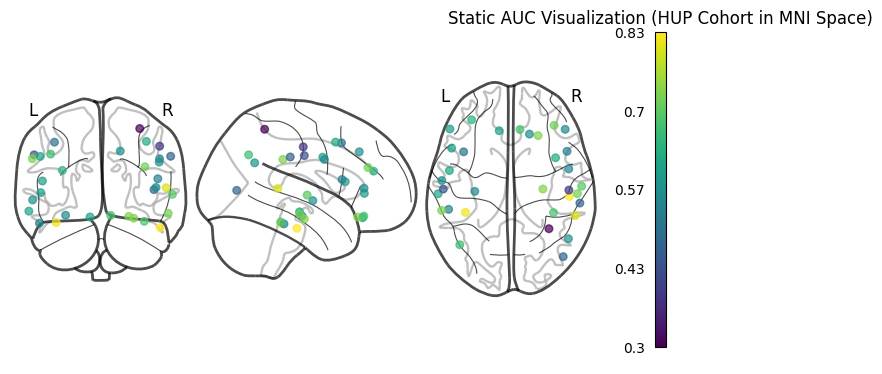

In [ ]:
coords = aggregated_df[['mni_x', 'mni_y', 'mni_z']].values
auc_values = aggregated_df['AUC'].values

niplot.plot_markers(
    node_values=auc_values,
    node_coords=coords,
    node_cmap='viridis',
    node_vmin=auc_values.min(),
    node_vmax=auc_values.max(),
    node_size=30
)
plt.title('Static AUC Visualization (HUP Cohort in MNI Space)', ha='center')
plt.show()

In [93]:
print("AUC Column Summary:")
print(merged_df['AUC'].describe())
print("Any NaN values in AUC column?", merged_df['AUC'].isna().any())

AUC Column Summary:
count    2807.000000
mean        0.620135
std         0.110639
min         0.300000
25%         0.550000
50%         0.611111
75%         0.715909
max         0.832168
Name: AUC, dtype: float64
Any NaN values in AUC column? False
